In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfea
import cartopy.io.shapereader as shapereader

In [13]:
# load file after executing global_city/pre/explore_int_ctycls.py
city_num = 211

rgndir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region'
glbdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
POP='vld_cty_'
SUF = '.gl5'
dtype = 'float32'
gl5shape = (2160, 4320)

exp_cand = np.fromfile(f'{glbdir}/dat/cty_int_/fig/intake_display_{POP}_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
exp_cand_cropped = exp_cand[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
exp_cand_masked = np.ma.masked_where(exp_cand_cropped==0, exp_cand_cropped)
cm = colors.ListedColormap(["#EEEEEE", "#AAAAAA"])

# estimated intake
intake = np.fromfile(f'{glbdir}/dat/cty_int_/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
intake_masked = np.ma.masked_where(intake_cropped==0, intake_cropped)
cmap_intake = colors.ListedColormap(['none', 'lime'])

In [2]:
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
# rivnxl in xy coord
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)

#######################################
# start ####
#######################################
city_num = 211

def exeption_rivergrid(city_num, riv_nxlonlat_cropped):
    # coord of purficication
    root_dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    prf_path = f"{root_dir}/dat/cty_prf_/vld_cty_/city_{city_num:08}.gl5"
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    prf_coords = np.where(prf == 1)
    print(f'citynum: {city_num}, coord of prfs: {prf_coords}')
    
    # save variable
    riv_path_array = np.zeros((2160, 4320))
    
    # initial grid
    for pid in range(len(prf_coords[0])):
        print(f'pid == {pid}, len(prf_coords) == {len(prf_coords[0])}')
        
        # down stream exploration
        target_coord = (prf_coords[0][pid], prf_coords[1][pid])
        visited_coords = set()
        while True:
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            target_row, target_col = target_coord
            next_coord = riv_nxlonlat_cropped[target_row, target_col]
            if next_coord.size == 0 or next_coord.shape != (2,):
                break
            target_coord = (next_coord[0], next_coord[1])

        # update riv_path_array
        for row, col in visited_coords:
            riv_path_array[row, col] = city_num
    
        # up stream exploration
        def explore_upstream(target_coord, visited_coords, riv_nxlonlat_cropped, city_num):
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                target_row, target_col = target_coord
                matched_coords = np.argwhere(np.all(target_coord == riv_nxlonlat_cropped, axis=2))
                if len(matched_coords) == 0:
                    break
                unvisited_matched = [tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords]
                for up_coord in unvisited_matched:
                    explore_upstream(up_coord, visited_coords, riv_nxlonlat_cropped, city_num)

        # execute function
        target_coord = (prf_coords[0][pid], prf_coords[1][pid])
        visited_coords = set()
        explore_upstream(target_coord, visited_coords, riv_nxlonlat_cropped, city_num)
        
        # update riv_path_array
        for row, col in visited_coords:
            riv_path_array[row, col] = city_num
    
    return riv_path_array
    
riv_path_array =  exeption_rivergrid(city_num, riv_nxlonlat_cropped)

citynum: 211, coord of prfs: (array([644]), array([777]))
pid == 0, len(prf_coords) == 1


In [4]:
def explore(city_num):
    print('-------------------------')
    print(f"city_num {city_num}")

#----------------------------------------------------------------------------------------
#   Init
#----------------------------------------------------------------------------------------

    NAME= 'W5E5'
    MAP= '.CAMA'
    SUF = '.gl5'
    dtype= 'float32'
    POP='vld_cty_'
    year_start = 2019
    year_end = 2020
    lat_num = 2160
    lon_num = 4320
    can_exp = 2    # grid radius for canal grid modification exploring
    exp_range = 98 # grid radius of exploring square area 500km
    distance_condition = 100 #km

#----------------------------------------------------------------------------------------
#   PATH
#----------------------------------------------------------------------------------------

    root_dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    dis_dir = f"{root_dir}/dat/riv_out_"
    can_in_path = f"{root_dir}/dat/can_ext_/existing_origin{SUF}"
    can_out_path = f"{root_dir}/dat/can_ext_/existing_destination_1{SUF}"
    elv_path = f"{root_dir}/dat/elv_min_/elevtn{MAP}{SUF}"
    rivnum_path = f"{root_dir}/dat/riv_num_/rivnum{MAP}{SUF}"
    nonprf_path = f"{root_dir}/dat/non_prf_/{POP}/nonprf_flag.txt"
    prf_path = f"{root_dir}/dat/cty_prf_/{POP}/city_{city_num:08}{SUF}"
    cnt_path = f"{root_dir}/dat/cty_cnt_/gpw4/modified/city_{city_num:08}{SUF}"
    msk_path = f"{root_dir}/dat/{POP}/city_{city_num:08}{SUF}"
    savepath = f"{root_dir}/dat/cty_int_/{POP}/city_{city_num:08}{SUF}"
    displaypath = f'{root_dir}/dat/cty_int_/fig/intake_display_{POP}_{city_num:08}{SUF}'

#----------------------------------------------------------------------------------------
#   Whether valid mask or not
#----------------------------------------------------------------------------------------

    if not os.path.exists(msk_path):
        print(f"{city_num} is invalid mask")
        return

#----------------------------------------------------------------------------------------
#   Load
#----------------------------------------------------------------------------------------

    # river discharge data
    for year in range(year_start, year_end, 1):

        dis_path = f"{dis_dir}/{NAME}LR__{year}0000{SUF}"
        riv_dis_tmp = np.fromfile(dis_path, dtype=dtype).reshape(lat_num, lon_num)

        if year == year_start:
            riv_dis = riv_dis_tmp
        else:
            riv_dis = riv_dis + riv_dis_tmp

    # annual average discharge
    riv_dis = riv_dis/(year_end - year_start)

    # canal map
    can_in = np.fromfile(can_in_path, dtype=dtype).reshape(lat_num, lon_num)
    can_out = np.fromfile(can_out_path, dtype=dtype).reshape(lat_num, lon_num)

    # elevation map
    elv = np.fromfile(elv_path, dtype=dtype).reshape(lat_num, lon_num)

    # water shed number map
    rivnum = np.fromfile(rivnum_path, dtype=dtype).reshape(lat_num, lon_num)

    # city mask data
    city_mask = np.fromfile(msk_path, dtype=dtype).reshape(lat_num, lon_num)

    # purification plant location
    prf = np.fromfile(prf_path, dtype=dtype).reshape(lat_num, lon_num)

    # no purification flag
    with open(nonprf_path, 'r') as input_file:
        lines = input_file.readlines()
    line = lines[city_num-1]
    parts = line.split('|')
    parts = [item.strip() for item in parts]
    no_prf_flag = parts[1]
    if no_prf_flag == 'True':
        print(f"no_prf_flag: {no_prf_flag}")

#-------------------------------------------------------------------------------------------
#   JOB
#-------------------------------------------------------------------------------------------

    # prf location
    indices = np.where(prf == 1)
    prfelv_lst = elv[prf==1]
    #print(prfelv_lst) [7, 71.1, 119.4]
    lat_coords = indices[0]
    lon_coords = indices[1]
    #print(x_coords, y_coords) > [648, 651, 652] [3834, 3831, 3830]

    # prf watershed
    rivnum_unq = np.unique(rivnum[prf == 1])
    cty_rivnum = [i for i in rivnum_unq]
    #print(cty_rivnum) # [848.0, 2718.0, 4850.0, 6065.0, 0]

    # city center data
    city_center = np.fromfile(cnt_path, dtype=dtype).reshape(lat_num, lon_num)

    # indices of city center
    indices = np.where(city_center==1) # tuple
    latcnt = int(indices[0])
    loncnt = int(indices[1])
    #print(x) #651
    #print(y) #3836

    # init maximum river discharge
    riv_max = 0

    # canal_out around 100km of city center
    can_mask = np.zeros((lat_num, lon_num))
    for ibt_lat in range(-exp_range, exp_range+1):
        for ibt_lon in range(-exp_range, exp_range+1):
            can_mask[latcnt+ibt_lat, loncnt+ibt_lon] = 1
    can_check = can_mask*can_out
    #print(np.sum(can_check)) # 0

    # main river
    riv_path_array =  exeption_rivergrid(city_num, riv_nxlonlat_cropped)
    ng_grids = np.where(riv_path_array != 0)
    y_coords = ng_grids[0]
    x_coords = ng_grids[1]
    ng_coords = set(zip(y_coords, x_coords))

    # display data
    display_data = np.zeros((lat_num, lon_num))

    # if canal exists
    if np.sum(can_check)>0:
        canal = 'canal_yes'
        if prfelv_lst.size == 0:
            print("no purification plant")
        else:

            # canal number
            canal_unq = np.unique(can_check)
            canal_lst = [uni for uni in canal_unq if uni>0]
            #print(canal_lst) # [100.]

            # canal unique number loop
            for canal_num in canal_lst:
                # indices of canal in
                can_ind = np.where(can_in==canal_num) # tuple
                can_ind = np.array(can_ind)
                #print(can_ind) # [[711, 711, 717], [2529, 2541, 2547]]
                #print(can_ind.shape) # (2, 3)

                # canal grid loop
                for C in range(can_ind.shape[1]):
                    display_data[can_out==can_check[can_ind[0, C],can_ind[1, C]]] = 1
                    # explore grids around canal
                    for p in range(-can_exp, can_exp):
                        for q in range(-can_exp, can_exp):
                            Y = can_ind[0, C] + p
                            X = can_ind[1, C] + q
                            display_data[Y, X] = 2
                            # maximum or not check
                            if riv_dis[Y,X]/1000. > riv_max:
                                # update riv
                                riv_max = riv_dis[Y,X]/1000.
                                YY = Y
                                XX = X

    # if no canal
    else:
        canal = 'canal_no'

        ### make search list
        search_lst = []
        for p in range(-exp_range, exp_range+1, 1):
            for q in range(-exp_range, exp_range+1, 1):
                    Y, X = latcnt + p, loncnt + q

                    # not explored yet
                    if 0 <= Y < lat_num and 0<= X < lon_num:
                        # distance btw prf and explored grid
                        d_list = []

                        for prf_y, prf_x in zip(lat_coords, lon_coords):
                            LON, LAT = xy2lonlat(X, Y)
                            prf_lon, prf_lat = xy2lonlat(prf_x, prf_y)
                            distance = lonlat_distance(LAT, LON, prf_lat, prf_lon)
                            d_list.append(distance)

                        # closer than IBT max distance
                        d_min = np.min(d_list)
                        elv_min = prfelv_lst[np.argmin(d_list)]

                        if d_min <= distance_condition:
                            search_lst.append([riv_dis[Y, X], Y, X])
                            display_data[Y, X] = 1

                            # out of city mask
                            if city_mask[Y, X] != 1:

                                # intake point shoud be higher than elevation of closest purification plant
                                if elv[Y, X] > elv_min:

                                    # including same watershed
                                    if no_prf_flag == 'True':
                                        display_data[Y, X] = 2

                                        # check if maximum
                                        if riv_dis[Y, X]/1000. > riv_max:
                                            # update riv
                                            riv_max = riv_dis[Y, X]/1000.
                                            #print(f'riv_max {X}, {Y} updated {riv_max}')
                                            YY = Y
                                            XX = X
                                            print(f"distance: {d_min}")

                                    # include same water shed but not in same riverpath
                                    else:
                                        # river path (watershed) is not overlapped with updown stream of each prfs
                                        if (Y, X) not in ng_coords:
                                            display_data[Y, X] = 2

                                            # check if maximum
                                            if riv_dis[Y, X]/1000. > riv_max:
                                                # update riv
                                                riv_max = riv_dis[Y, X]/1000.
                                                #print(f'riv_max {X}, {Y} updated {riv_max}')
                                                YY = Y
                                                XX = X
                                                print(f"distance: {d_min}")

    if riv_max > 0:

        # save file for display check
        display_data[YY, XX] =                   3
        #display_data[city_mask == 1] =           4
        #display_data[city_center == 1] =         5

        # save file for binary
        intake = np.zeros((lat_num, lon_num))
        intake[YY, XX] = 1
        print(f"riv_max  {riv_max}\n"
              f"{canal}")

    else:
        print("no potential intake point\n"
              f"riv_max  {riv_max}\n"
              f"{canal}")
        intake = np.zeros((lat_num, lon_num))

    return intake, display_data

def xy2lonlat(x, y, lat_num=2160, lon_num=4320):
    if 0 <= x <= lon_num:
        loncnt = (x*360/lon_num) - 180
        latcnt = 90 - (y*180)/lat_num
    else:
        loncnt = 1e20
        latcnt = 1e20

    return loncnt, latcnt

def lonlat_distance(lat_a, lon_a, lat_b, lon_b):
    """" Hybeny's Distance Formula """
    pole_radius = 6356752.314245
    equator_radius = 6378137.0
    radlat_a = math.radians(lat_a)
    radlon_a = math.radians(lon_a)
    radlat_b = math.radians(lat_b)
    radlon_b = math.radians(lon_b)

    lat_dif = radlat_a - radlat_b
    lon_dif = radlon_a - radlon_b
    lat_ave = (radlat_a + radlat_b) / 2

    e2 = (math.pow(equator_radius, 2) - math.pow(pole_radius, 2)) \
            / math.pow(equator_radius, 2)

    w = math.sqrt(1 - e2 * math.pow(math.sin(lat_ave), 2))

    m = equator_radius * (1 - e2) / math.pow(w, 3)

    n = equator_radius / w

    distance = math.sqrt(math.pow(m * lat_dif, 2) \
                + math.pow(n * lon_dif * math.cos(lat_ave), 2))

    return distance / 1000

intake, display_data = explore(city_num=211)

-------------------------
city_num 211


/tmp/ipykernel_3775/1185450125.py:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  latcnt = int(indices[0])
/tmp/ipykernel_3775/1185450125.py:114: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loncnt = int(indices[1])


citynum: 211, coord of prfs: (array([644]), array([777]))
pid == 0, len(prf_coords) == 1
riv_max  822.9204375
canal_yes


In [5]:
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

#---------------------------------------------------------------------------------------------------------------
#  city maskの枠だけを表示
#---------------------------------------------------------------------------------------------------------------
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # right

    return ax

import random
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
from matplotlib.patches import Rectangle

#---------------------------------------------------------------------------------------------------------------
# 流域IDと色の紐付け(kakiuchi's method) this is deprecated
#---------------------------------------------------------------------------------------------------------------

def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    return result

def is_grayish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    deviation = max(r, g, b) - min(r, g, b)
    return deviation <= 20

def is_blueish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return (b - r > 120 and b - g > 120) or (r < 100 and g< 100 and b > 150)  # If blue is dominant and significantly larger
    
def is_whitish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return  (r + g + b)/3 > 230

def get_filtered_colors():
    all_colors = list(CSS4_COLORS.values())
    result = []
    ng_color = ['#3F2E6' '#00FFFF', '#B3F2E6', '#7FFFD4', '#2A3F54', '#B3F2F9', '#00FF00']
    for color in all_colors:
        if color not in ng_color \
            and not is_grayish(color) \
            and not is_whitish(color):
            result.append(color)
    return result

def make_cmap(Rivnum_masked_array):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)

    # 流域に固有の色を割り振る
    filtered_colors = get_filtered_colors()
    #random.seed(42)
    #colors_list = (random.choices(filtered_colors, k=num_colors))
    colors_list = filtered_colors[:num_colors]

    # -1<=x<0に透明色を追加
    colors_list.insert(0, '#00000000')

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1
    
def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat

In [6]:
#
glbdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
#
city_num = 211
#
resolution = 12
POP='vld_cty_'
#
SUF = '.gl5'
dtype = 'float32'
gl5shape = (2160, 4320)
#
# region
left = -117
right = -114
bottom = 35
top = 38
#
nx, ny = (right - left)*resolution, (top - bottom)*resolution
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
#
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution

citynum: 211, coord of prfs: (array([644]), array([777]))
pid == 0, len(prf_coords) == 1


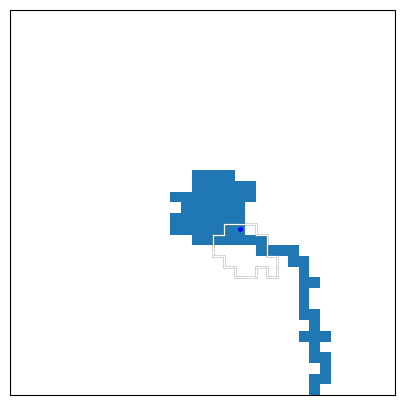

In [7]:
projection = ccrs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': projection})
ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
ax.gridlines(visible=False)

# draw riv_path_array
riv_path_array =  exeption_rivergrid(city_num, riv_nxlonlat_cropped)
tmp = np.ma.masked_where(riv_path_array == 0, riv_path_array)
im = ax.imshow(tmp, extent=(-180,180,-90,90), transform=ccrs.PlateCarree(), cmap='tab20')

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
msk_dir = f'{h08dir}/global_city/dat/vld_cty_'
ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
mask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
draw_mask_sotowaku((-180,180,-90,90), mask, ax=ax, sotowaku_color='black', linewidth=1)

root_dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
prf_path = f"{root_dir}/dat/cty_prf_/vld_cty_/city_{city_num:08}.gl5"
prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
prf_coords = np.where(prf == 1)
latlon_coords = [grid_to_latlon(row, col, (-180,180,-90,90)) for row, col in zip(prf_coords[0], prf_coords[1])]

for lon, lat in latlon_coords:
    ax.plot(lon, lat, marker='o', color='blue', markersize=2.5, transform=ccrs.PlateCarree())

ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

plt.show()

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


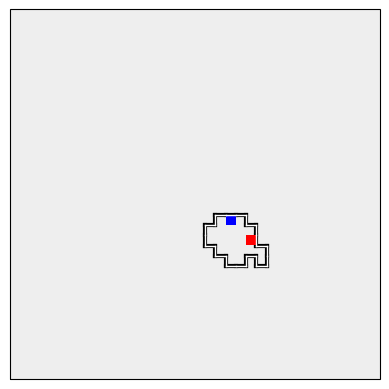

In [8]:
# result of above code
# 1: explored area
# 2: candidate points
exp_cand_cropped = display_data[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
exp_cand_masked = np.ma.masked_where(exp_cand_cropped==0, exp_cand_cropped)
cm = colors.ListedColormap(["#EEEEEE", "#AAAAAA"])

# estimated intake
intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
#intake_masked = np.ma.masked_where(intake_cropped==0, intake_cropped)
cmap_intake = colors.ListedColormap(['none', 'lime'])

# city mask
mask = np.fromfile(f'{glbdir}/dat/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
mask_cropped = mask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

# josui
josui = np.fromfile(f'{glbdir}/dat/cty_prf_/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
josui_cropped = josui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
cmap_josui = colors.ListedColormap(['none', 'blue'])

# gesui
gesui = np.fromfile(f'{glbdir}/dat/cty_swg_/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
gesui_cropped = gesui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
cmap_gesui = colors.ListedColormap(['none', 'red'])

# draw
projection = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.set_extent(img_extent)
ax.coastlines()

#intake, display_data

im = ax.imshow(exp_cand_masked, extent=img_extent, transform=projection, cmap=cm, vmin=1, vmax=2, zorder=0)
im2 = ax.imshow(intake_cropped, extent=img_extent, transform=projection, cmap=cmap_intake, zorder=2)
im3 = ax.imshow(josui_cropped, extent=img_extent, transform=projection, cmap=cmap_josui, zorder=2)
im4 = ax.imshow(gesui_cropped, extent=img_extent, transform=projection, cmap=cmap_gesui, zorder=2)
draw_mask_sotowaku(img_extent, mask_cropped, ax=ax, sotowaku_color='black')

# tokyo shapefile
shpfilename = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
provinces = shapereader.Reader(shpfilename).records()
provinces_of_japan = filter(
    lambda province: province.attributes['admin'] == 'Japan', provinces)
for province in provinces_of_japan:
    geometry = province.geometry
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='none', linestyle=':', zorder=0)

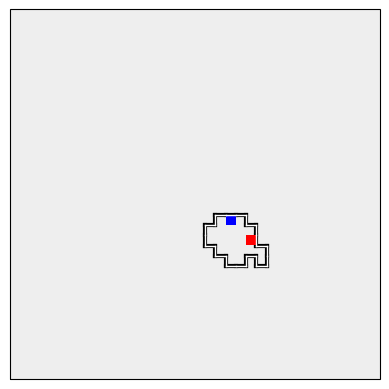

In [9]:
# result of saved file
# explored file
# 1: explored area
# 2: candidate points
exp_cand = np.fromfile(f'{glbdir}/dat/cty_int_/fig/intake_display_{POP}_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
exp_cand_cropped = exp_cand[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
exp_cand_masked = np.ma.masked_where(exp_cand_cropped==0, exp_cand_cropped)
cm = colors.ListedColormap(["#EEEEEE", "#AAAAAA"])

# estimated intake
intake = np.fromfile(f'{glbdir}/dat/cty_int_/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
intake_cropped = intake[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
#intake_masked = np.ma.masked_where(intake_cropped==0, intake_cropped)
cmap_intake = colors.ListedColormap(['none', 'lime'])

# city mask
mask = np.fromfile(f'{glbdir}/dat/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
mask_cropped = mask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]

# josui
josui = np.fromfile(f'{glbdir}/dat/cty_prf_/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
josui_cropped = josui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
cmap_josui = colors.ListedColormap(['none', 'blue'])

# gesui
gesui = np.fromfile(f'{glbdir}/dat/cty_swg_/{POP}/city_{city_num:08}{SUF}', dtype='float32').reshape(gl5shape)
gesui_cropped = gesui[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
cmap_gesui = colors.ListedColormap(['none', 'red'])

# draw
projection = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.set_extent(img_extent)
ax.coastlines()

#intake, display_data

im = ax.imshow(exp_cand_masked, extent=img_extent, transform=projection, cmap=cm, vmin=1, vmax=2, zorder=0)
#im2 = ax.imshow(intake_cropped, extent=img_extent, transform=projection, cmap=cmap_intake, zorder=2)
im2 = ax.imshow(intake_cropped, extent=img_extent, transform=projection, cmap=cmap_intake, zorder=2)
im3 = ax.imshow(josui_cropped, extent=img_extent, transform=projection, cmap=cmap_josui, zorder=2)
im4 = ax.imshow(gesui_cropped, extent=img_extent, transform=projection, cmap=cmap_gesui, zorder=2)
draw_mask_sotowaku(img_extent, mask_cropped, ax=ax, sotowaku_color='black')

# tokyo shapefile
shpfilename = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
provinces = shapereader.Reader(shpfilename).records()
provinces_of_japan = filter(
    lambda province: province.attributes['admin'] == 'Japan', provinces)
for province in provinces_of_japan:
    geometry = province.geometry
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='none', linestyle=':', zorder=0)

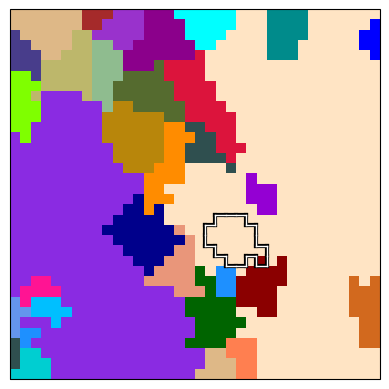

In [10]:
rivnum = np.fromfile(f'{glbdir}/dat/riv_num_/rivnum.CAMA.gl5', dtype='float32').reshape(gl5shape)
rivnum_cropped = rivnum[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
rivnum_cropped = np.ma.masked_where(rivnum_cropped == 0, rivnum_cropped)
num_colors, index_dict, cmap = make_cmap(rivnum_cropped)
data_masked = np.ma.masked_where(rivnum_cropped >= 1e20, rivnum_cropped)
data_filled = data_masked.filled(0)
indexed_data = np.vectorize(get_index)(data_filled, index_dict)

# draw
projection = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.set_extent(img_extent)
ax.coastlines()

im = ax.imshow(intake_cropped, extent=img_extent, transform=projection, cmap=cmap_intake, zorder=1)
im2 = ax.imshow(indexed_data, extent=img_extent, transform=projection, cmap=cmap, vmin=-2, zorder=0)
draw_mask_sotowaku(img_extent, mask_cropped, ax=ax, sotowaku_color='black')

shpfilename = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
provinces = shapereader.Reader(shpfilename).records()
provinces_of_japan = filter(
    lambda province: province.attributes['admin'] == 'Japan', provinces)
for province in provinces_of_japan:
    geometry = province.geometry
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='none', linestyle=':', zorder=10)